<a href="https://colab.research.google.com/github/Erre-vicu/PEA-DS-DMC/blob/main/Trabajo_Final_Robinson_R%C3%ADos_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicamos el modelo ARIMA a STORE

## Importamos librerías

In [ ]:
!pip install pmdarima
import warnings
warnings.filterwarnings("ignore")
def fxn():
  warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  fxn()

import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import pandas as pd
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from math import sqrt

%matplotlib inline
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["text.color"] = "k"

import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##  Cargamos y trasformamos la data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Time Series Forecasting/Datos/SalesDemand.csv",index_col="date", parse_dates=["date"], sep=";")
df.head()

,store,item,sales
date,,,
2013-01-01,1.0,1.0,13.0
2013-02-01,1.0,1.0,11.0
2013-03-01,1.0,1.0,14.0
2013-04-01,1.0,1.0,13.0
2013-05-01,1.0,1.0,10.0


In [ ]:
#Eliminamos los valores nulos
print("df antes de dropna =>", df.isnull().sum())
print(df.shape)
print("***"*12)

df.dropna(inplace=True)
print("df despues de dropna =>", df.isnull().sum())
print(df.shape)

df antes de dropna => store    45000
item     45000
sales    45000
dtype: int64
(958000, 3)
************************************
df despues de dropna => store    0
item     0
sales    0
dtype: int64
(913000, 3)


In [ ]:
#El análisis se hará con la tienda con mayor cantidad de ventas, en este caso la tienda 2
df.groupby(["store"]).agg({"sales":"sum"}).sort_values(by=["sales"],ascending=False)

,sales
store,
2.0,6120128.0
8.0,5856169.0
3.0,5435144.0
10.0,5360158.0
9.0,5025976.0
4.0,5012639.0
1.0,4315603.0
5.0,3631016.0
6.0,3627670.0


In [ ]:
#Filtramos y agrupamos la información por la tienda 2.0
df_store_2=df[["sales"]][df["store"]==2.0]

In [ ]:
df_store_2.head()

,sales
date,
2013-01-01,12.0
2013-02-01,16.0
2013-03-01,16.0
2013-04-01,20.0
2013-05-01,16.0


In [ ]:
#Usamos la función resample para llevar la data de días a mes y sumamos las ventas
df_store_2_m=df_store_2.copy()
df_store_2_m=df_store_2_m.resample("M").sum()

In [ ]:
df_store_2_m.head()

,sales
date,
2013-01-31,68952.0
2013-02-28,67549.0
2013-03-31,83072.0
2013-04-30,85758.0
2013-05-31,92777.0


In [ ]:
df_store_2_m.shape

(60, 1)

##  Visualización de la data

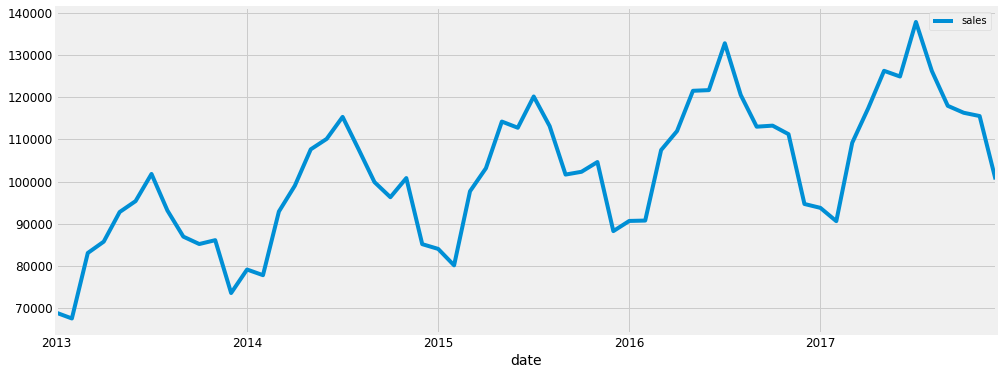

In [ ]:
y = df_store_2_m.copy()
y.plot(figsize=(15,6))
plt.show()

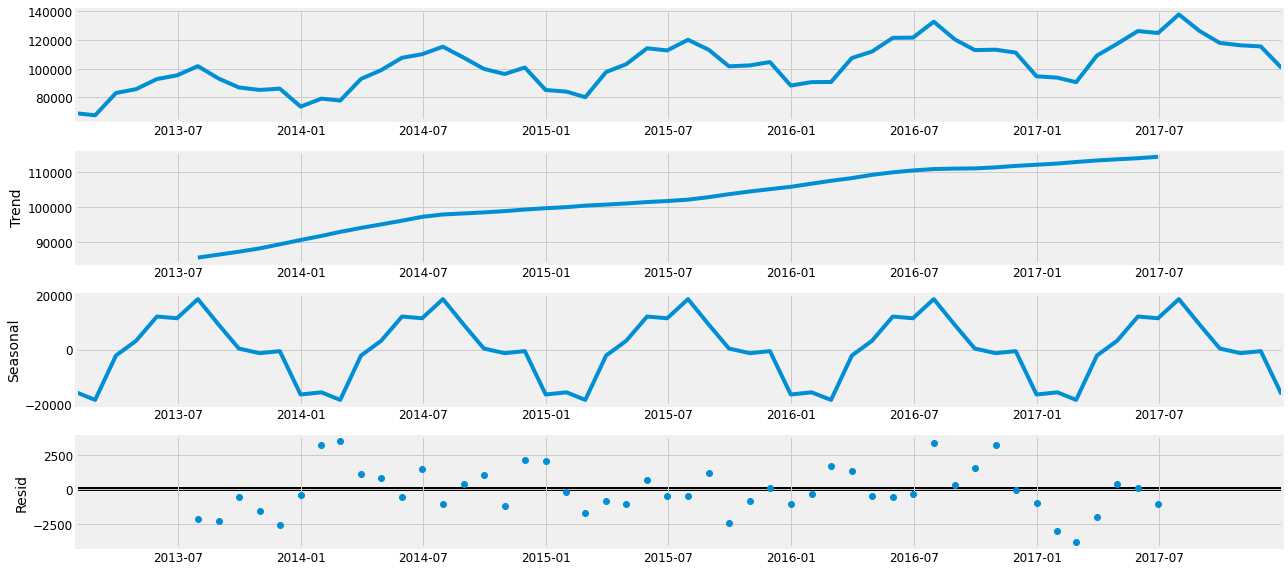

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

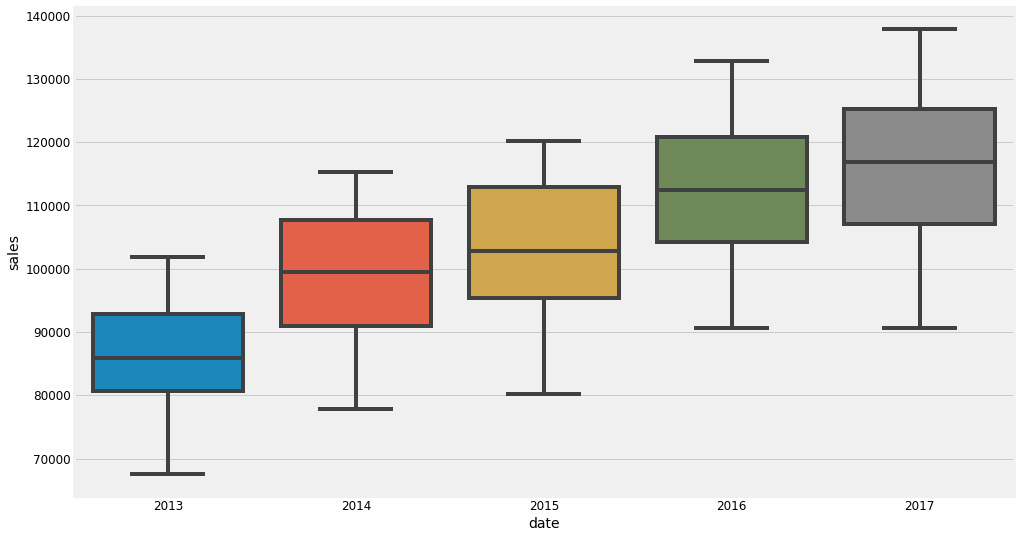

In [ ]:
plt.figure(figsize=(15,9))
sns.boxplot(data=y, x=y.index.year, y=y["sales"])
plt.show()

## Hacemos la prueba de Dickey-Fuller para probar estacionalidad

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y.sales)
print("ADF Statistics: %f" % result[0])
print("p-value: %f" % result[1])

ADF Statistics: -4.415399
p-value: 0.000279


Dado que el ***P-valor = 0.000279*** es menor que el nivel de significancia, aceptamos la H1: Es estacionaria. 

## Gráficos ACF y PACF

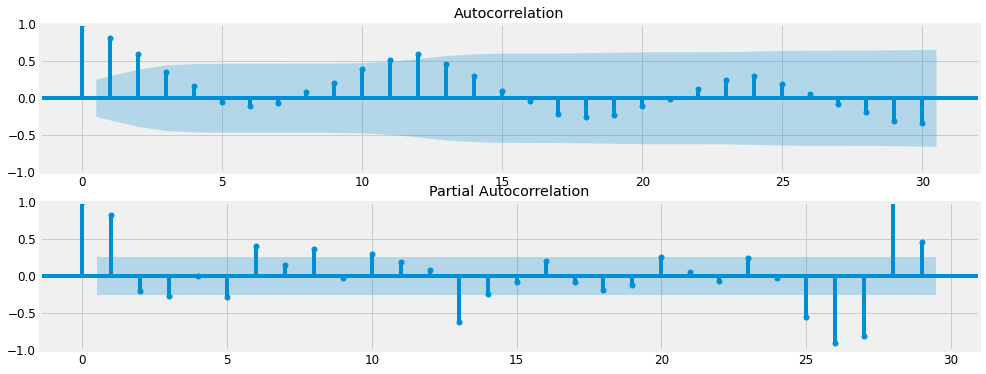

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(211)
plot_acf(y.sales, ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(y.sales, ax=plt.gca(), lags=29)
plt.show()

## Transformación Logarítmica

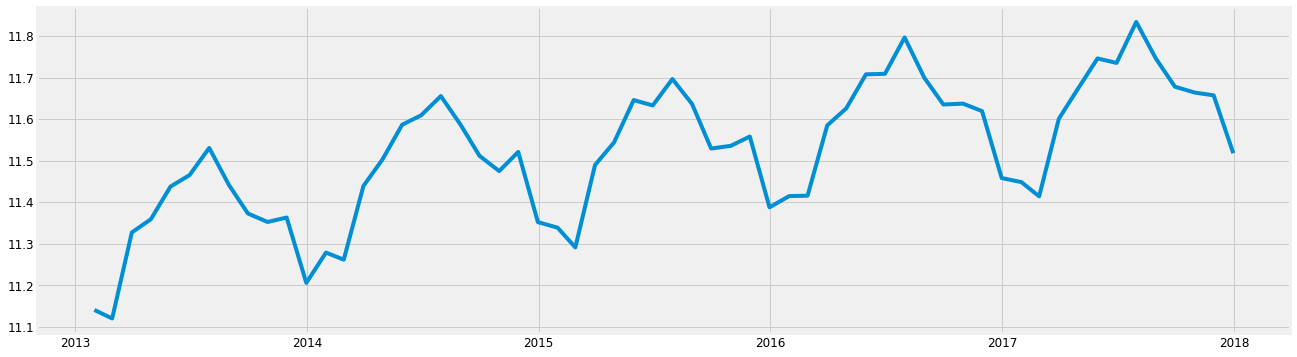

In [ ]:
ts_log = np.log(y)
plt.figure(figsize=(20,6))
plt.plot(ts_log)
plt.show()

## Técnica de Diferenciación

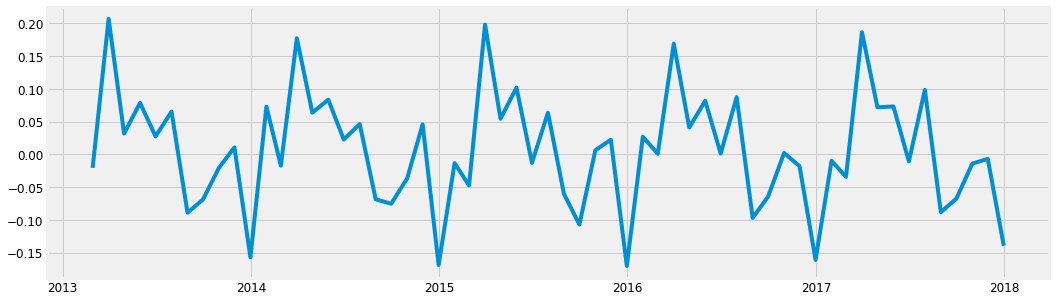

In [ ]:
ts_log_diff = ts_log.sales - ts_log.sales.shift()
plt.figure(figsize=(16,5))
plt.plot(ts_log_diff)
plt.show()

## Predicción de Series de Tiempo

## Autoregresión (AR)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from random import random

In [ ]:
ts_log_diff=ts_log_diff.dropna()

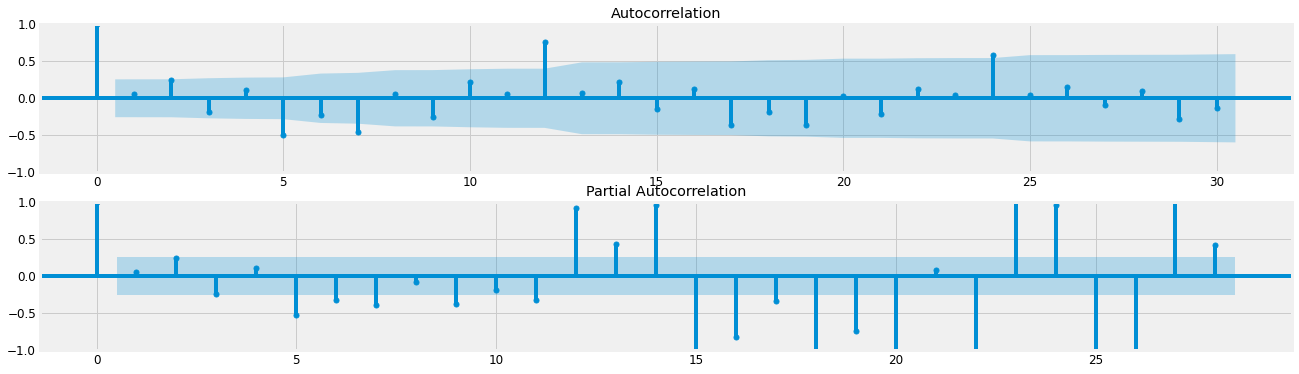

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca(), lags=28)
plt.show()

In [ ]:
#fit Model
model = AutoReg(ts_log_diff, 4, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  sales   No. Observations:                   59
Model:                     AutoReg(4)   Log Likelihood                  60.201
Method:               Conditional MLE   S.D. of innovations              0.081
Date:                Sat, 25 Feb 2023   AIC                           -108.402
Time:                        03:02:52   BIC                            -96.358
Sample:                    06-30-2013   HQIC                          -103.744
                         - 12-31-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.011      0.051      0.959      -0.021       0.022
sales.L1       0.1479      0.139      1.067      0.286      -0.124       0.419
sales.L2       0.2223      0.134      1.659      0.0

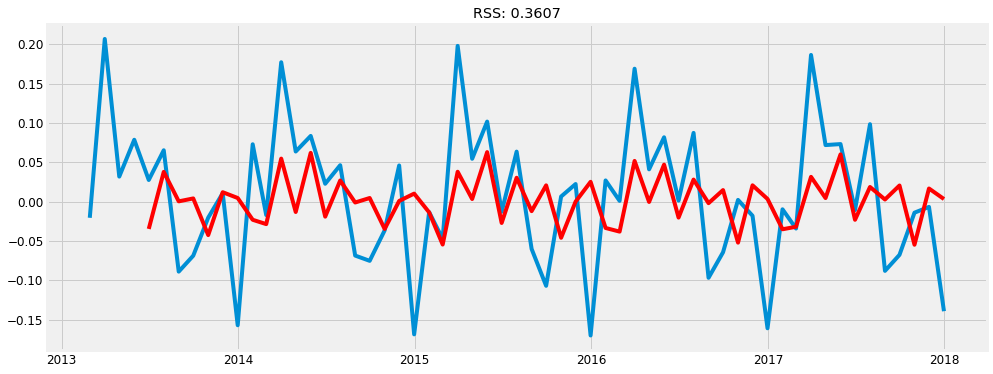

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color="red")
plt.title("RSS: %.4f"% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

## Revirtiendo las Transformaciones

## **Valores Ajustados o Predichos**

In [ ]:
predictions_ARIMA_diff=pd.Series(model_fit.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2013-06-30   -0.034721
2013-07-31    0.037836
2013-08-31    0.000342
2013-09-30    0.004055
2013-10-31   -0.042557
Freq: M, dtype: float64

## Suma Acumulativa para revertir la diferenciación:

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2013-06-30   -0.034721
2013-07-31    0.003115
2013-08-31    0.003457
2013-09-30    0.007512
2013-10-31   -0.035045
Freq: M, dtype: float64

## Agregar el valor del primer mes que se elimino previamente al diferenciar

In [ ]:
predictions_ARIMA_log = pd.Series(ts_log.sales.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date
2013-01-31    11.141166
2013-02-28    11.141166
2013-03-31    11.141166
2013-04-30    11.141166
2013-05-31    11.141166
Freq: M, dtype: float64

## Tomando el exponente para invertir la transformación del registro:

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_ARIMA.head(10)

date
2013-01-31    68952.000000
2013-02-28    68952.000000
2013-03-31    68952.000000
2013-04-30    68952.000000
2013-05-31    68952.000000
2013-06-30    66599.024706
2013-07-31    69167.153120
2013-08-31    69190.812209
2013-09-30    69471.925699
2013-10-31    66577.430901
Freq: M, dtype: float64

Text(0.5, 1.0, 'RMSE: 33976.5100')

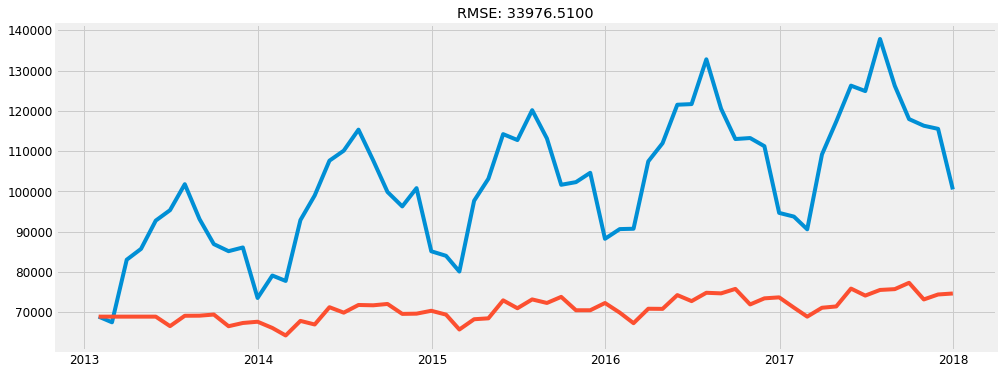

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y.sales)
plt.plot(predictions_ARIMA)
plt.title("RMSE: %.4f" % np.sqrt(np.nansum((predictions_ARIMA-y.sales)**2)/len(y.sales)))

## Métricas de puntuación de calidad de pronóstico

* **R-Cuadrado**
* **Error Absoluto Medio**
* **Median Absolute Error**
* **Error Medio Cuadrado**
* **Error logarítmico medio cuadrado**
* **Error medio absolutode porcentaje**

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [ ]:
#Mean Absolute error
mean_absolute_error(y.sales, predictions_ARIMA)

31107.549140444728

In [ ]:
#Mean Squared Error
mean_squared_error(y.sales, predictions_ARIMA)

1154403229.1645803

In [ ]:
#Error logarítmico medio cuadrado
mean_squared_log_error(y.sales, predictions_ARIMA)

0.14088465440891385

In [ ]:
#Error medio porcentual absoluto
def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [ ]:
mean_absolute_percentage_error(y.sales, predictions_ARIMA)

29.0647808251208

## Función para evaluar el pronóstico utilizando las métricas anteriores:


In [ ]:
def evaluate_forecast(y, pred):
  results = pd.DataFrame({"r2_score":r2_score(y, pred),
                          }, index=[0])
  results["mean_absolute_error"] = mean_absolute_error(y, pred)
  results["median_absolute_error"] = median_absolute_error(y, pred)
  results["mse"] = mean_squared_error(y, pred)
  results["msle"] = mean_squared_log_error(y, pred)
  results["mape"] = mean_absolute_percentage_error(y, pred)
  results["rmse"] = np.sqrt(results["mse"])
  return results

In [ ]:
evaluate_forecast(y.sales, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-3.562373,31107.54914,31894.425836,1.154403e+09,0.140885,29.064781,33976.509962


## Media Móvil (MA)

In [ ]:
#MA Example
from statsmodels.tsa.arima.model import ARIMA
from random import random

#fit model
model = ARIMA(ts_log_diff, order=(0,0,2))
model_fit = model.fit()

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   59
Model:                 ARIMA(0, 0, 2)   Log Likelihood                  61.111
Date:                Sat, 25 Feb 2023   AIC                           -114.221
Time:                        03:02:53   BIC                           -105.911
Sample:                    02-28-2013   HQIC                          -110.978
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.019      0.323      0.747      -0.031       0.043
ma.L1          0.0946      0.210      0.450      0.653      -0.317       0.506
ma.L2          0.2006      0.294      0.683      0.494      -0.375       0.776
sigma2         0.0074      0.001      5.581      0.000       0.005       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.91   Prob(JB):                         0.92
Heteroskedasticity (H):               1.01   Skew:                            -0.00
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'RSS: 0.4361')

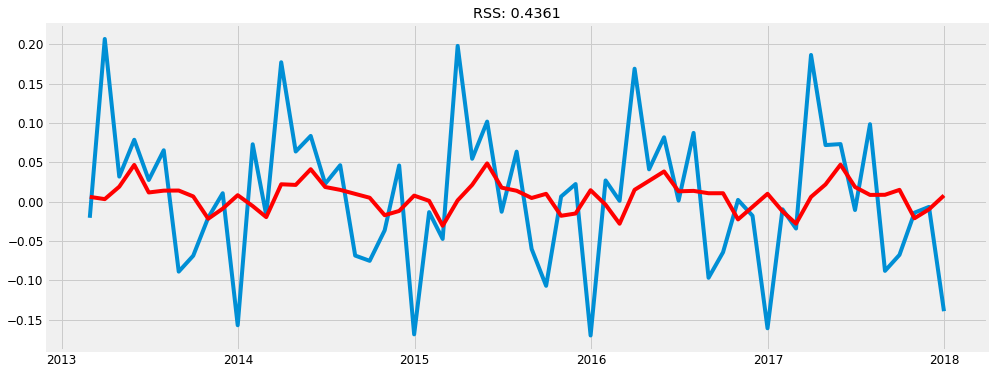

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color="red")
plt.title("RSS: %.4f" % np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Media móvil autoregresiva (ARMA)

In [ ]:
#Arma Example
from statsmodels.tsa.arima.model import ARIMA
from random import random

#fit model
model = ARIMA(ts_log_diff, order = (3,0,2))
model_fit=model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   59
Model:                 ARIMA(3, 0, 2)   Log Likelihood                  75.514
Date:                Sat, 25 Feb 2023   AIC                           -137.028
Time:                        03:02:53   BIC                           -122.485
Sample:                    02-28-2013   HQIC                          -131.351
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.003      1.927      0.054      -0.000       0.012
ar.L1          0.2739      0.200      1.366      0.172      -0.119       0.667
ar.L2          0.6668      0.123      5.408      0.000       0.425       0.908
ar.L3         -0.5992      0.167     -3.589      0.000      -0.926      -0.272
ma.L1         -0.0394      1.086     -0.036      0.971      -2.167       2.089
ma.L2         -0.9460      1.022     -0.925      0.355      -2.950       1.058
sigma2         0.0044      0.005      0.968      0.333      -0.004       0.013
===================================================================================
Ljung-Box (L1) (Q):                   1.54   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.22   Prob(JB):                         0.84
Heteroskedasticity (H):               0.89   Skew:                            -0.12
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'RSS: 0.2763')

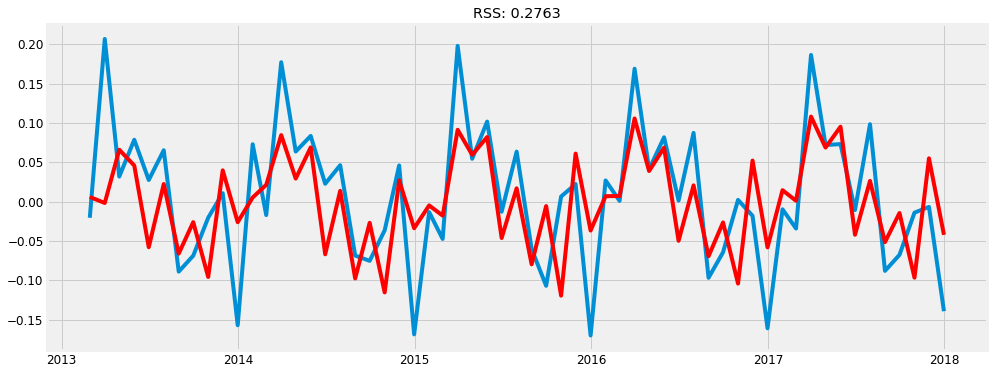

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color="red")
plt.title("RSS: %.4f" % np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Media móvil integrada autoregresiva (ARIMA)

In [ ]:
#Diferenciación Data
ts = y.sales - y.sales.shift()
ts.dropna(inplace=True)

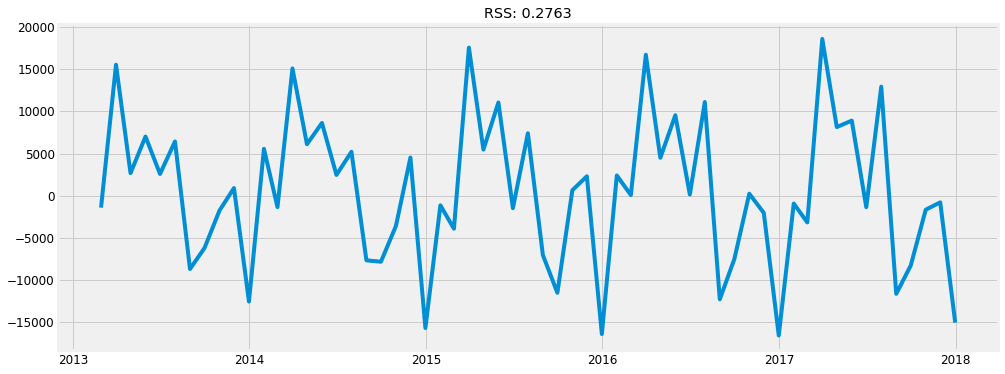

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts)
plt.title("RSS: %.4f"% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

## Gráficos ACF y PACF después de diferenciar

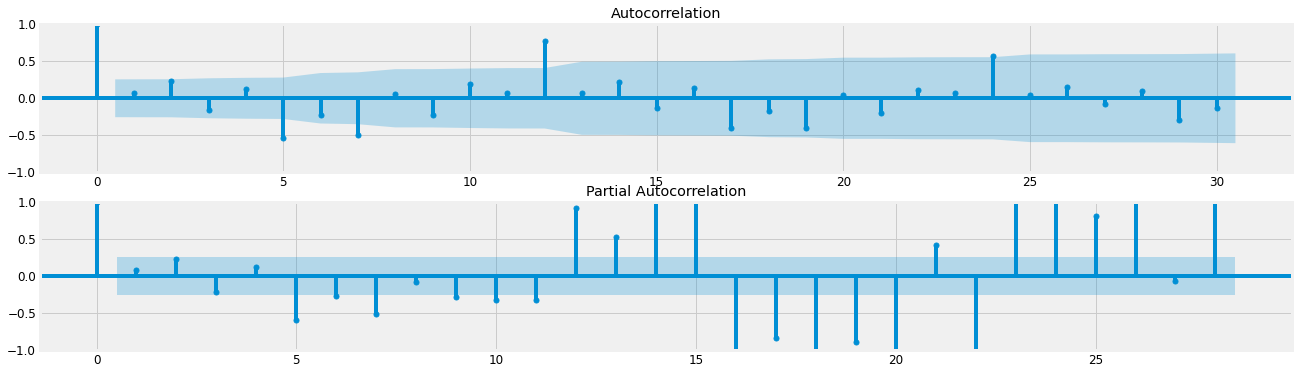

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(211)
plot_acf(ts, ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(ts, ax=plt.gca(), lags=28)
plt.show()

In [ ]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

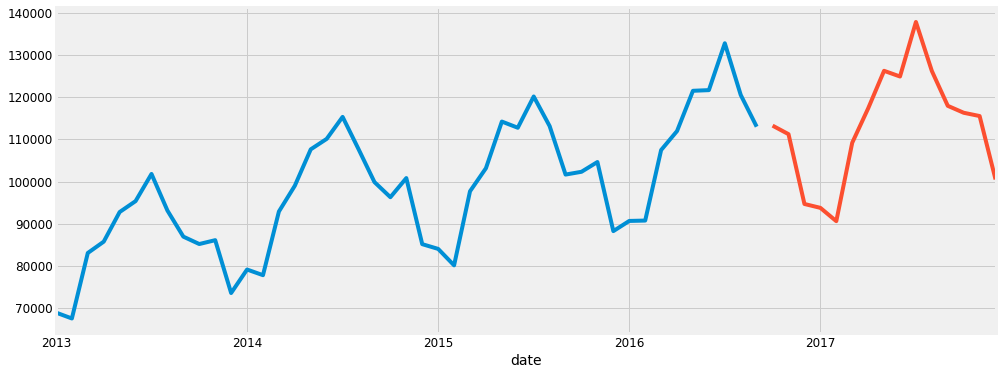

In [ ]:
#plotting the data
plt.figure(figsize=(15,6))
train["sales"].plot()
valid["sales"].plot()
plt.show()

## Auto ARIMA

In [ ]:
#Building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=917.538, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=923.923, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=925.931, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=926.018, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=922.557, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=917.334, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=923.028, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=918.919, Time=0.68 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=925.403, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=916.469, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=921.732, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=917.660, Time=0.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=922.858, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

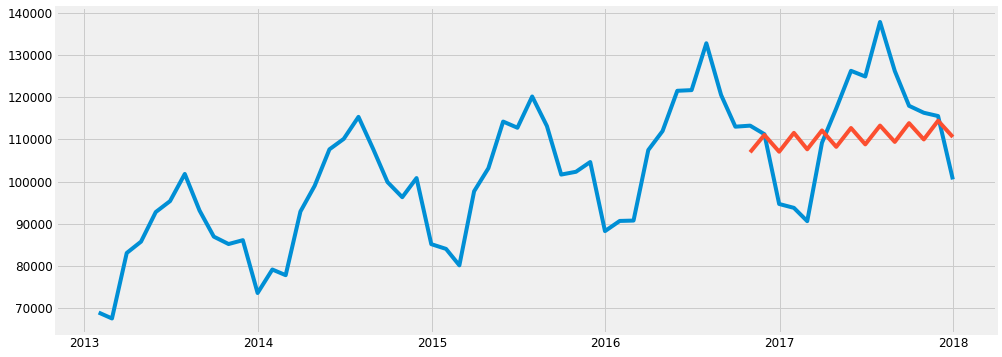

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast, index = valid.index, columns=["Prediction"])

plt.figure(figsize=(15,6))
plt.plot(y.sales, label="Train")
plt.plot(forecast, label="Prediction")
plt.show()

In [ ]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.066837,10555.648184,10066.472755,1.585633e+08,0.012658,NaN,12592.19138


## Promedio Móvil integrado estacional autorregresivo (SARIMA)




In [ ]:
#SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

#fit the model
model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,1,12))
model_fit=model.fit(disp=False) 

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [ ]:
#Report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)

print("RMSE: {}, MSE:{}".format(rmse, mse))

RMSE: 6424.503497564659, MSE:41274245.19022053


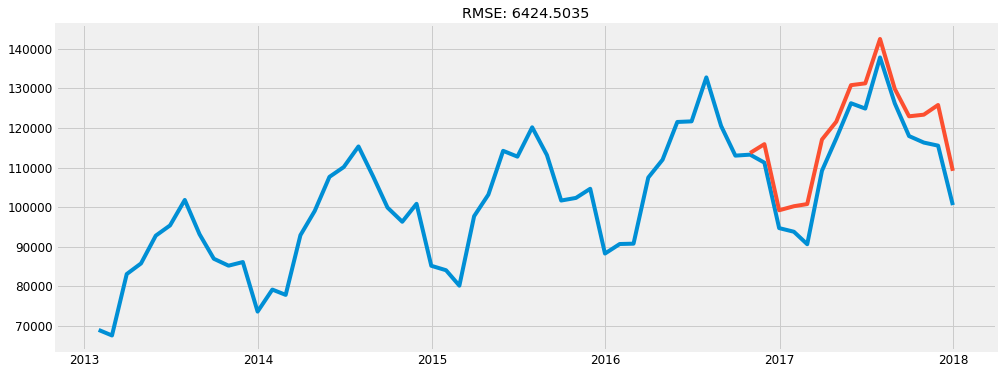

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y)
plt.plot(predictions)
plt.title("RMSE: %.4f"% rmse)
plt.show()

In [ ]:
evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.757096,5905.509123,4991.939385,4.127425e+07,0.003376,NaN,6424.503498


## Auto-SARIMA

In [ ]:
#building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action="ignore", supress_warnings=True, seasonal=True, m=12, stepwise=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=645.194, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=649.817, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=635.339, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=700.430, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=643.393, Time=0.25 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=626.171, Time=0.75 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=638.724, Time=0.34 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=600.838, Time=2.17 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=624.971, Time=0.85 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=627.474, Time=3.17 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=626.242, Time=1.55 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=624.889, Time=0.77 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=607.170, Time=3.05 sec
 ARIMA(0,0,2)(2,1,1)[12] intercept   

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(2, 1, 1, 12),
      suppress_warnings=True)

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()

In [ ]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred, index = valid.index, columns=["Prediction"])

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast, index = valid.index, columns=["Prediction"])

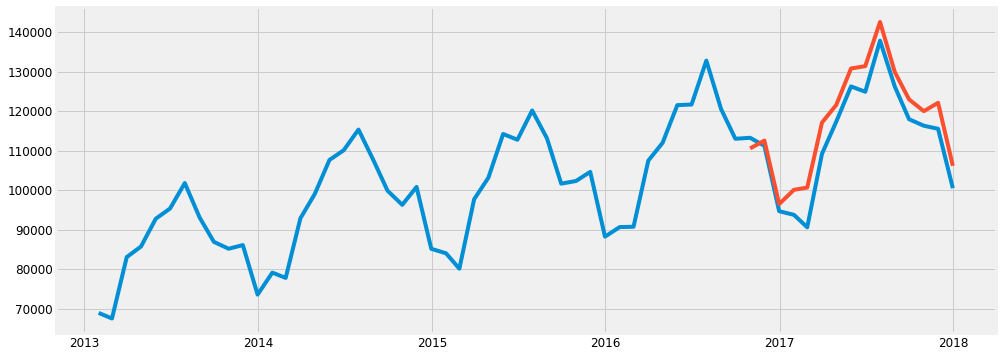

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y.sales, label="Train")
plt.plot(forecast, label="Prediction")
plt.show()

In [ ]:
evaluate_forecast(y[start_index:end_index], forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.824993,4978.21829,4725.677782,2.973716e+07,0.002471,NaN,5453.179091


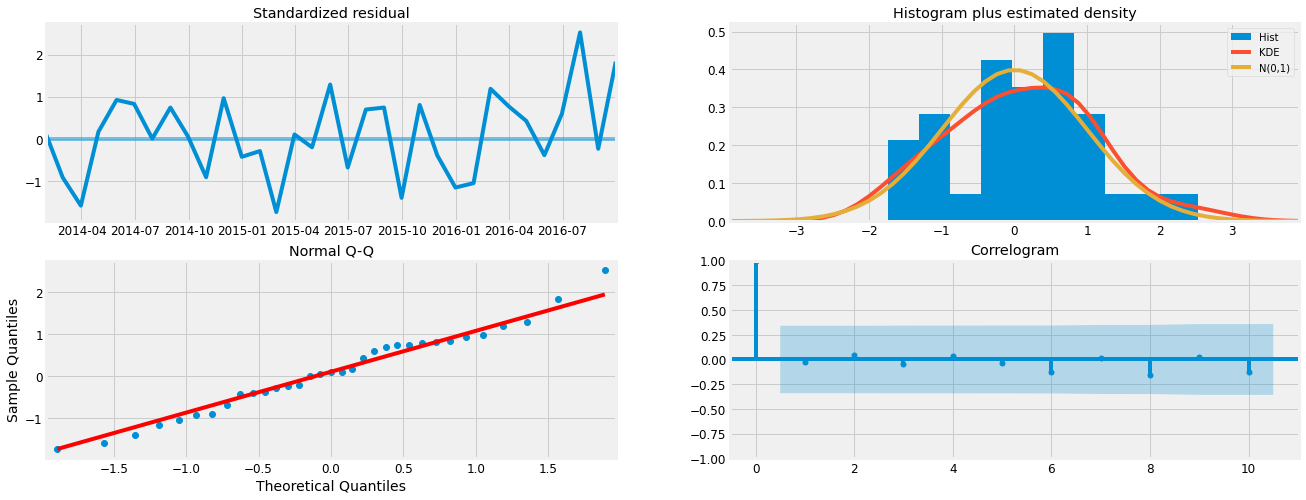

In [ ]:
model.plot_diagnostics(figsize=(20,8))
plt.show()

# Aplicamos el modelo ARIMA al ITEM

In [ ]:
#El análisis se hará con el item de mayor cantidad de ventas, en este caso el item 15
df.groupby(["item"]).agg({"sales":"sum"}).sort_values(by=["sales"],ascending=False)

,sales
item,
15.0,1607442.0
28.0,1604713.0
13.0,1539621.0
18.0,1538876.0
25.0,1473334.0
45.0,1471467.0
38.0,1470330.0
22.0,1469971.0
36.0,1406548.0


In [ ]:
#Filtramos y agrupamos la información por la tienda 2.0
df_item=df[["sales"]][df["item"]==15.0]

In [ ]:
#Usamos la función resample para llevar la data de días a mes y sumamos las ventas
df_item_m=df_item.copy()
df_item_m=df_item_m.resample("M").sum()

In [ ]:
df_item_m.head()

,sales
date,
2013-01-31,18345.0
2013-02-28,17700.0
2013-03-31,21658.0
2013-04-30,22367.0
2013-05-31,24204.0


In [ ]:
df_item_m.shape

(60, 1)

## Visualizando la data

<Figure size 1080x432 with 0 Axes>

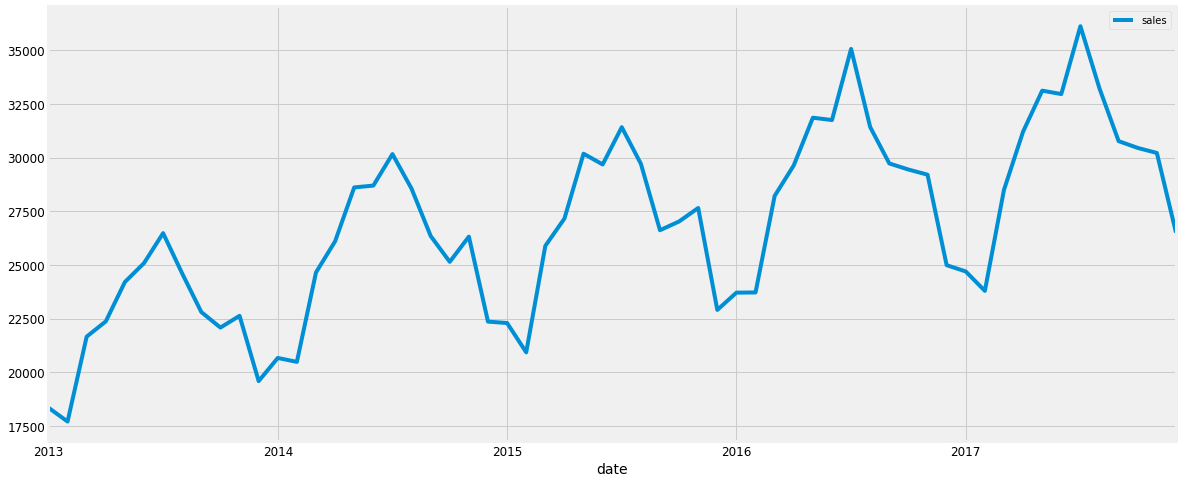

In [ ]:
y = df_item_m.copy()
plt.figure(figsize=(15,6))
y.plot()
plt.show()

In [ ]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

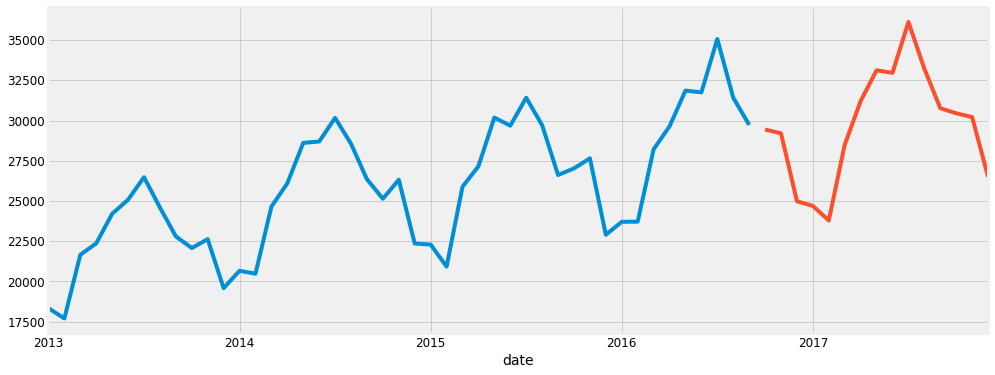

In [ ]:
#plotting the data
plt.figure(figsize=(15,6))
train["sales"].plot()
valid["sales"].plot()
plt.show()

## Auto ARIMA

In [ ]:
#Building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=808.150, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=810.111, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=810.201, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=806.739, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.670 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

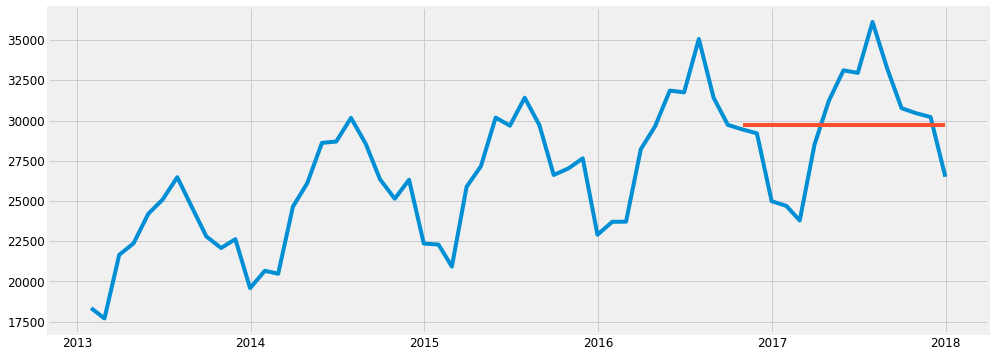

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast, index = valid.index, columns=["Prediction"])

plt.figure(figsize=(15,6))
plt.plot(y.sales, label="Train")
plt.plot(forecast, label="Prediction")
plt.show()

In [ ]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-0.0002,2748.333333,3220.0,11632158.2,0.013777,NaN,3410.594992


## Promedio Móvil integrado estacional autorregresivo (SARIMA)


In [ ]:
#SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

#fit the model
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,1,1,12))
model_fit=model.fit(disp=False) 

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [ ]:
#Report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)

print("RMSE: {}, MSE:{}".format(rmse, mse))

RMSE: 1946.6784783734115, MSE:3789557.098162221


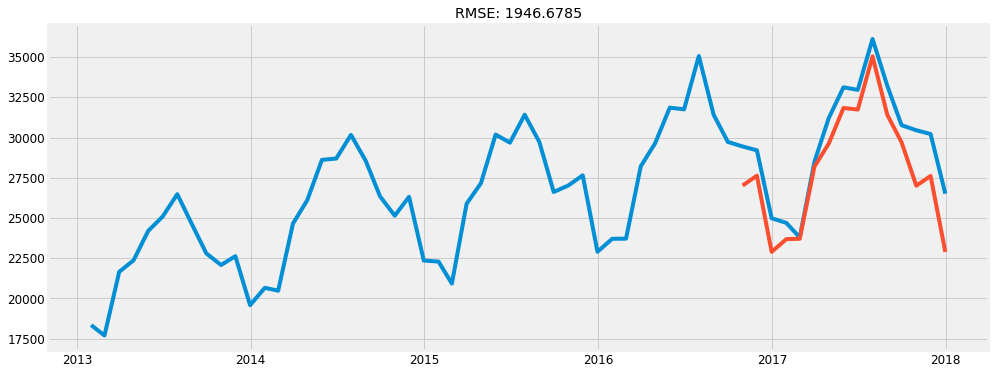

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y)
plt.plot(predictions)
plt.title("RMSE: %.4f"% rmse)
plt.show()

In [ ]:
evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.674152,1679.795974,1572.998262,3.789557e+06,0.005004,NaN,1946.678478


## Auto-SARIMA

In [ ]:
#building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action="ignore", supress_warnings=True, seasonal=True, m=12, stepwise=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=532.605, Time=0.88 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=561.329, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=551.656, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=543.046, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=613.104, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=551.995, Time=1.21 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=534.763, Time=2.20 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=534.814, Time=1.27 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=532.070, Time=1.08 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=526.387, Time=0.89 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=543.772, Time=0.17 sec
 ARIMA(1,0,2)(1,1,2)[12] intercept   : AIC=532.772, Time=0.83 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AI

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True)

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()

In [ ]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred, index = valid.index, columns=["Prediction"])

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast, index = valid.index, columns=["Prediction"])

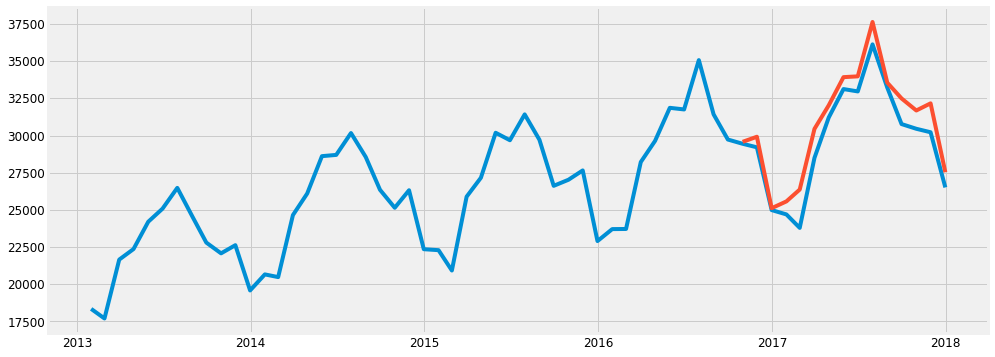

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y.sales, label="Train")
plt.plot(forecast, label="Prediction")
plt.show()

In [ ]:
evaluate_forecast(y[start_index:end_index], forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.852397,1116.84672,1013.00015,1.716597e+06,0.002036,NaN,1310.18955


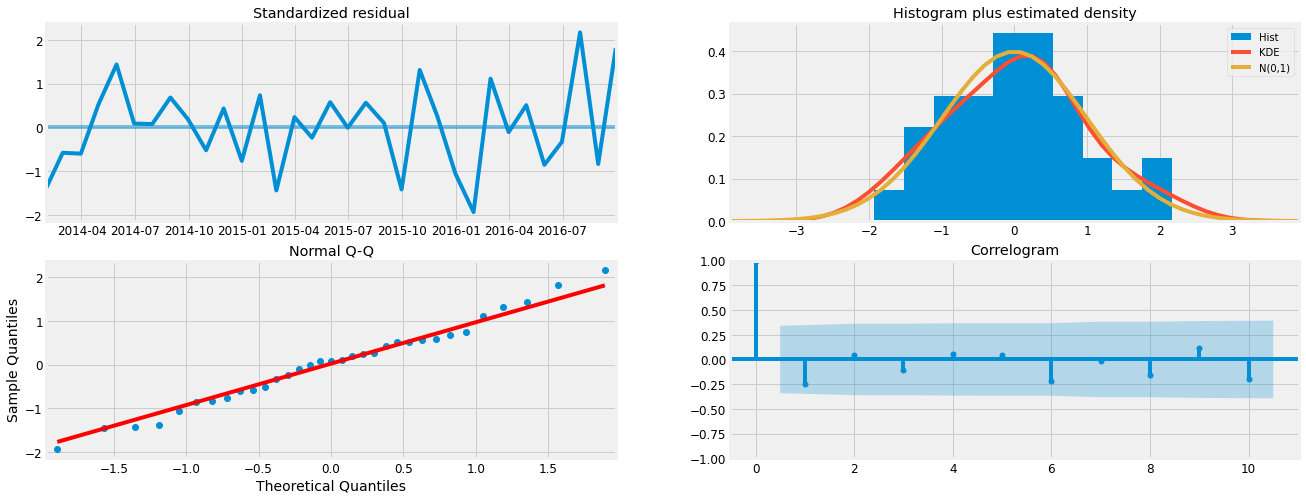

In [ ]:
model.plot_diagnostics(figsize=(20,8))
plt.show()

Para los dos casos se puede observar que es mejor usar el método ARIMA, y el Auto-Arima es el que nos brinda un mejor R2 - score con 85%.